In [1]:
import xarray as xr
import numpy as np
from midas.rectgrid import *

In [2]:
ds=xr.open_dataset('/work/mjh/WenHao/NWAtl/19920101.ocean_NWA.nc')
#ds=xr.open_dataset('NWAtl/parent_state.nc')
sgrid=supergrid(file='NWAtl/ocean_hgrid.nc')
grid=quadmesh(supergrid=sgrid)

In [3]:
(nj,ni)=(ds['ssh'].shape[1],ds['ssh'].shape[2])
print(ni,nj)
jst=13
ni=ni-8;nj=jst+grid.jm
print(ni,nj)
print(grid.im,grid.jm)
print(grid.lonq[0],grid.lonq[-1])
print(ds.xq_sub01[0].load().data,ds.xq_sub01[ni].load().data)
print(grid.latq[0],grid.latq[-1])
print(ds.yq_sub01[jst].load().data,ds.yq_sub01[nj].load().data)

176 224
168 210
168 197
-100.0 -58.0
-100.0 -58.0
15.073066511750687 54.052509039229584
15.073066511750687 54.052509039229584


In [4]:
seg_001_temp=ds['temp'].isel(xh_sub02=slice(0,ni),yh_sub02=slice(jst-1,jst+1)).mean(axis=2,keepdims=True)
seg_001_salt=ds['salt'].isel(xh_sub02=slice(0,ni),yh_sub02=slice(jst-1,jst+1)).mean(axis=2,keepdims=True)
seg_001_ssh=ds['ssh'].isel(xh_sub02=slice(0,ni),yh_sub02=slice(jst-1,jst+1)).mean(axis=1,keepdims=True)
seg_001_u=ds['u'].isel(xq_sub01=slice(0,ni+1),yh_sub01=slice(jst-1,jst+1)).mean(axis=2,keepdims=True)
seg_001_v=ds['v'].isel(xh_sub01=slice(0,ni),yq_sub01=slice(jst,jst+1))

seg_002_temp=ds['temp'].isel(xh_sub02=slice(ni-1,ni+1),yh_sub02=slice(jst,nj)).mean(axis=3,keepdims=True)
seg_002_salt=ds['salt'].isel(xh_sub02=slice(ni-1,ni+1),yh_sub02=slice(jst,nj)).mean(axis=3,keepdims=True)
seg_002_ssh=ds['ssh'].isel(xh_sub02=slice(ni-1,ni+1),yh_sub02=slice(jst,nj)).mean(axis=2,keepdims=True)
seg_002_u=ds['u'].isel(xq_sub01=slice(ni,ni+1),yh_sub01=slice(jst,nj))
seg_002_v=ds['v'].isel(xh_sub01=slice(ni-1,ni+1),yq_sub01=slice(jst,nj+1)).mean(axis=3,keepdims=True)


In [5]:
seg_001_temp=seg_001_temp.rename({'yh_sub02':'lat','xh_sub02':'pos'})
seg_001_salt=seg_001_salt.rename({'yh_sub02':'lat','xh_sub02':'pos'})
seg_001_ssh=seg_001_ssh.rename({'yh_sub02':'lat','xh_sub02':'pos'})
seg_001_u=seg_001_u.rename({'yh_sub01':'lat','xq_sub01':'pos'})
seg_001_v=seg_001_v.rename({'yq_sub01':'lat','xh_sub01':'pos'})

seg_002_temp=seg_002_temp.rename({'yh_sub02':'pos','xh_sub02':'lon'})
seg_002_salt=seg_002_salt.rename({'yh_sub02':'pos','xh_sub02':'lon'})
seg_002_ssh=seg_002_ssh.rename({'yh_sub02':'pos','xh_sub02':'lon'})
seg_002_u=seg_002_u.rename({'yh_sub01':'pos','xq_sub01':'lon'})
seg_002_v=seg_002_v.rename({'yq_sub01':'pos','xh_sub01':'lon'})



In [23]:
params=[]

params.append({'suffix':'_segment_001','dim0':2,'temp_in':seg_001_temp,'salt_in':seg_001_salt,\
               'tr_out':'obc_ts_south.nc',\
               'u_in':seg_001_u,'v_in':seg_001_v,'u_out':'obc_u_south.nc','v_out':'obc_v_south.nc',\
               'ssh_in':seg_001_ssh,'ssh_out':'obc_ssh_south.nc'})

params.append({'suffix':'_segment_002','dim0':3,'temp_in':seg_002_temp,'salt_in':seg_002_salt,\
               'tr_out':'obc_ts_east.nc',\
               'u_in':seg_002_u,'v_in':seg_002_v,'u_out':'obc_u_east.nc','v_out':'obc_v_east.nc',\
               'ssh_in':seg_002_ssh,'ssh_out':'obc_ssh_east.nc'})

for pr in params:
    ds_temp=pr['temp_in']
    ds_salt=pr['salt_in']
    ds_u=pr['u_in']
    ds_v=pr['v_in']
    zl=ds_temp.zl
    zi=0.5*(np.roll(zl,shift=-1)+zl)
    zi[-1]=6500.
    ds_temp['z_i']=zi
    dz=zi-np.roll(zi,shift=1)
    dz[0]=zi[0]
    ds_temp['dz']=dz
    nt=ds_temp.time.shape[0]
    nx=ds_temp.pos.shape[0]
    dz=np.tile(ds_temp.dz.data[np.newaxis,:,np.newaxis],(nt,1,nx))
    
    if pr['dim0']==3:
        dz=dz[:,:,:,np.newaxis]
        da_dz=xr.DataArray(dz,coords=[('time',ds_temp.time),('zl',ds_temp.zl),('pos',ds_temp.pos),('lon',ds_u.lon.data)])
    elif pr['dim0']==2:
        dz=dz[:,:,np.newaxis,:]
        da_dz=xr.DataArray(dz,coords=[('time',ds_temp.time),('zl',ds_temp.zl),('lat',ds_v.lat.data),('pos',ds_temp.pos)])
    ds_temp.time.attrs['modulo']=' '
    ds_salt.time.attrs['modulo']=' '
    da_temp=xr.DataArray(ds_temp.ffill(dim='pos',limit=None).ffill(dim='zl').fillna(0.))
    da_salt=xr.DataArray(ds_salt.ffill(dim='pos',limit=None).ffill(dim='zl').fillna(0.))
    ds_=xr.Dataset({'temp'+pr['suffix']:da_temp,'salt'+pr['suffix']:da_salt,\
                    'dz_temp'+pr['suffix']:da_dz,'dz_salt'+pr['suffix']:da_dz})
    for v in ds_:
        ds_[v].encoding['_FillValue']=1.e20    
    ds_['time'].encoding['_FillValue']=1.e20
    ds_['pos'].encoding['_FillValue']=1.e20
    ds_['pos'].encoding['_FillValue']=1.e20
    ds_['zl'].encoding['_FillValue']=1.e20
    ds_.drop_vars('z_i')
    ds_.drop_vars('dz')
    
    if pr['dim0']==3:
        ds_['lon'].encoding['_FillValue']=1.e20
    else:
        ds_['lat'].encoding['_FillValue']=1.e20
    
    ds_.to_netcdf(pr['tr_out'],unlimited_dims=('time'))
    
    ds_u.time.attrs['modulo']=' '
    ds_v.time.attrs['modulo']=' '
    da_u=xr.DataArray(ds_u.ffill(dim='pos',limit=None).ffill(dim='zl').fillna(0.))
    #da_u=da_u.expand_dims('dim_0',pr['dim0'])
    da_v=xr.DataArray(ds_v.ffill(dim='pos',limit=None).ffill(dim='zl').fillna(0.))
    #da_v=da_v.expand_dims('dim_0',pr['dim0'])
    if pr['dim0']==3:
        dzu=np.tile(ds_temp.dz.data[np.newaxis,:,np.newaxis,np.newaxis],(nt,1,nx,1))
        dzv=np.tile(ds_temp.dz.data[np.newaxis,:,np.newaxis,np.newaxis],(nt,1,nx+1,1))
        da_dzu=xr.DataArray(dzu,coords=[('time',ds_u.time),('zl',ds_u.zl),('pos',ds_u.pos),('lon',da_u.lon)])
        da_dzv=xr.DataArray(dzv,coords=[('time',ds_v.time),('zl',ds_v.zl),('pos',ds_v.pos),('lon',da_u.lon)])
        ds_u=xr.Dataset({'u'+pr['suffix']:da_u,'dz_u'+pr['suffix']:da_dzu})
        ds_v=xr.Dataset({'v'+pr['suffix']:da_v,'dz_v'+pr['suffix']:da_dzv})
    elif pr['dim0']==2:
        dzu=np.tile(ds_temp.dz.data[np.newaxis,:,np.newaxis,np.newaxis],(nt,1,1,nx+1))
        dzv=np.tile(ds_temp.dz.data[np.newaxis,:,np.newaxis,np.newaxis],(nt,1,1,nx))
        da_dzu=xr.DataArray(dzu,coords=[('time',ds_u.time),('zl',ds_u.zl),('lat',da_u.lat),('pos',ds_u.pos)])
        da_dzv=xr.DataArray(dzv,coords=[('time',ds_v.time),('zl',ds_v.zl),('lat',da_v.lat),('pos',ds_v.pos)])
        ds_u=xr.Dataset({'u'+pr['suffix']:da_u,'dz_u'+pr['suffix']:da_dzu})
        ds_v=xr.Dataset({'v'+pr['suffix']:da_v,'dz_v'+pr['suffix']:da_dzv})

    for v in ds_u:
        #print(v)
        ds_u[v].encoding['_FillValue']=1.e20
    for v in ds_v:
    #    print(v)
        ds_v[v].encoding['_FillValue']=1.e20
      
    ds_u['time'].encoding['_FillValue']=1.e20
    ds_u['pos'].encoding['_FillValue']=1.e20
    ds_v['time'].encoding['_FillValue']=1.e20
    ds_v['pos'].encoding['_FillValue']=1.e20
    if pr['dim0']==3:
        ds_u['lon'].encoding['_FillValue']=1.e20
        ds_v['lon'].encoding['_FillValue']=1.e20
        ds_v=ds_v.assign_coords({'lon':ds_u.lon})
    else:
        ds_u['lat'].encoding['_FillValue']=1.e20
        ds_v['lat'].encoding['_FillValue']=1.e20
        ds_u=ds_u.assign_coords({'lat':ds_v.lat})

    ds_u['zl'].encoding['_FillValue']=1.e20
    ds_v['zl'].encoding['_FillValue']=1.e20

    
    ds_u.to_netcdf(pr['u_out'],unlimited_dims=('time'))
    ds_v.to_netcdf(pr['v_out'],unlimited_dims=('time'))

    ds=pr['ssh_in']
    ds.time.attrs['modulo']=' '
    da_ssh=xr.DataArray(ds.ffill(dim='pos',limit=None).fillna(0.))
    #da_ssh=da_ssh.expand_dims('dim_0',pr['dim0']-1)
    ds_=xr.Dataset({'ssh'+pr['suffix']:da_ssh})
    for v in ds_:
        ds_[v].encoding['_FillValue']=1.e20 
    ds_['time'].encoding['_FillValue']=1.e20
    ds_['pos'].encoding['_FillValue']=1.e20
    if pr['dim0']==3:
        ds_['lon'].encoding['_FillValue']=1.e20
    else:
        ds_['lat'].encoding['_FillValue']=1.e20

    ds_.to_netcdf(pr['ssh_out'],unlimited_dims=('time'))

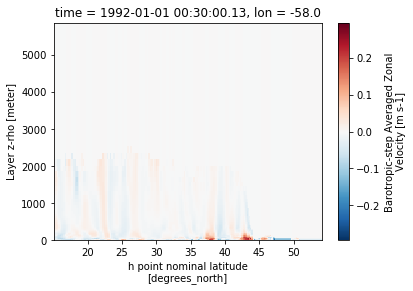

In [25]:
ds_u['u_segment_002'].isel(time=slice(0,1)).plot()